# Classify forest types based on information about the area

## Upload libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import catboost

In [2]:
# Fix the seed to have the reproducable results
SEED = 2019

In [3]:
# Fix target
TARGET = 'Cover_Type'

## Upload data

In [5]:
train = pd.read_csv('./data/train.csv', sep=',', index_col=0)

In [6]:
print(train.shape)
train.head(5)

(15120, 55)


Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
Id                                                               
1        2596      51      3                               258   
2        2590      56      2                               212   
3        2804     139      9                               268   
4        2785     155     18                               242   
5        2595      45      2                               153   

    Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
Id                                                                    
1                                0                              510   
2                               -6                              390   
3                               65                             3180   
4                              118                             3090   
5                               -1                              391   

    Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
Id                                                 
1             221             232            148   
2             220             235            151   
3             234             238            135   
4             238             238            122   
5             220             234            150   

    Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
Id                                      ...                             
1                                 6279  ...            0            0   
2                                 6225  ...            0            0   
3                                 6121  ...            0            0   
4                                 6211  ...            0            0   
5                                 6172  ...            0            0   

    Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
Id                                                                    
1             0            0            0            0            0   
2             0            0            0            0            0   
3             0            0            0            0            0   
4             0            0            0            0            0   
5             0            0            0            0            0   

    Soil_Type39  Soil_Type40  Cover_Type  
Id                                        
1             0            0           5  
2             0            0           5  
3             0            0           2  
4             0            0           2  
5             0            0           5  

[5 rows x 55 columns]

In [7]:
test = pd.read_csv('./data/test.csv', sep=',', index_col=0)

In [8]:
print(test.shape)
test.head(5)

(565892, 54)


Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
Id                                                                  
15121       2680     354     14                                 0   
15122       2683       0     13                                 0   
15123       2713      16     15                                 0   
15124       2709      24     17                                 0   
15125       2706      29     19                                 0   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
Id                                                                       
15121                               0                             2684   
15122                               0                             2654   
15123                               0                             2980   
15124                               0                             2950   
15125                               0                             2920   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
Id                                                    
15121            196             214            156   
15122            201             216            152   
15123            206             208            137   
15124            208             201            125   
15125            210             195            115   

       Horizontal_Distance_To_Fire_Points  ...  Soil_Type31  Soil_Type32  \
Id                                         ...                             
15121                                6645  ...            0            0   
15122                                6675  ...            0            0   
15123                                6344  ...            0            0   
15124                                6374  ...            0            0   
15125                                6404  ...            0            0   

       Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
Id                                                                       
15121            0            0            0            0            0   
15122            0            0            0            0            0   
15123            0            0            0            0            0   
15124            0            0            0            0            0   
15125            0            0            0            0            0   

       Soil_Type38  Soil_Type39  Soil_Type40  
Id                                            
15121            0            0            0  
15122            0            0            0  
15123            0            0            0  
15124            0            0            0  
15125            0            0            0  

[5 rows x 54 columns]

## Simble baseline

Let's try a few models to see the score, that we can get without any feature engineering.

### Data processing

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [11]:
# Any missed data?
train.isnull().values.any()

False

In [12]:
# Separate labels and features
train_data = train.drop([TARGET], axis = 1)
train_labels = train[TARGET]

print(train_data.shape)
print(train_labels.shape)

(15120, 54)
(15120,)


Some supporting functions:

In [13]:
# For prediction
def predict(model,filename, fit_model = False,  X=train_data, y=train_labels, test=test):
    if fit_model == True:
        model.fit(X, y)
        print('Model {} is fitted!'.format(model))
    predicts = model.predict(test)
    predicts = predicts.astype('int64')
    print('Model {} made the prediction!'.format(model))
    output = pd.DataFrame({'Id': test.index, 
                       'Cover_Type': predicts.reshape((test.shape[0], ))})
    output.to_csv(filename + '.csv', index=False)
    return predicts

In [14]:
# For KFold cross-validation
def cross_val(model, X=train_data, y=train_labels, n_splits = 3, scoring = 'accuracy', stratified = True, shuffle = False, verbose = True):
    if stratified == True:
        cv = StratifiedKFold(n_splits = n_splits, shuffle = shuffle, random_state=SEED)
    else:
        cv = KFold(n_splits = n_splits, shuffle = shuffle, random_state=SEED)
    cv_model = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    if verbose == True:
        print(cv_model)
        print('Mean: {0:.4f}'.format(cv_model.mean()))
    return cv_model, cv_model.mean()

Let's explore, how the classes are balanced

In [15]:
train[TARGET].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

Every class has the same number of samples! Very good: we can use the classification algorithms right away and apply cross-validation to validate them.

In [17]:
# Store indices of categorial features separately (useful for gradient boosting algorithms)
cat_features = [i for i in range(10, 54)]

In [18]:
# Leave some data for validation
(X_train, X_test, 
 y_train, y_test) = train_test_split(train_data, train_labels, 
                                     test_size=0.2, stratify = train_labels, 
                                     random_state=0)

### Classification models

Since we have multilabel classification, let's try Random Forest classifier:

### Random forest classifier

In [19]:
classifier_RF = RandomForestClassifier(random_state = 0, 
                        max_depth = 50, n_estimators = 200)

In [20]:
classifier_RF.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [21]:
cv_rf = cross_val(classifier_RF)

[0.79345238 0.77619048 0.78789683]
Mean: 0.7858


Let's make the first submisson for Random Forest (random_state = 0, max_depth = 50, n_estimators = 200)

In [22]:
# First submit with RF
predict(classifier_RF, 'RF_baseline')

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made the prediction!


array([2, 1, 2, ..., 3, 3, 6])

Public score became 0.75178. Not bad!

### Catboost Classifier

Now let's try more sophisticated algorithm, for example, gradient boosting. I am going to try catboost classifier:

In [23]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=1500,
    random_seed=43,
    learning_rate=0.1,
    loss_function='MultiClass',
    custom_loss=['Accuracy'],
    use_best_model=True
)
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7376956	test: 1.7395062	best: 1.7395062 (0)	total: 122ms	remaining: 3m 3s
1:	learn: 1.5931098	test: 1.5952399	best: 1.5952399 (1)	total: 188ms	remaining: 2m 21s
2:	learn: 1.4795499	test: 1.4819928	best: 1.4819928 (2)	total: 250ms	remaining: 2m 4s
3:	learn: 1.3866385	test: 1.3884077	best: 1.3884077 (3)	total: 315ms	remaining: 1m 57s
4:	learn: 1.3118243	test: 1.3140292	best: 1.3140292 (4)	total: 382ms	remaining: 1m 54s
5:	learn: 1.2508766	test: 1.2543496	best: 1.2543496 (5)	total: 449ms	remaining: 1m 51s
6:	learn: 1.1907182	test: 1.1952601	best: 1.1952601 (6)	total: 513ms	remaining: 1m 49s
7:	learn: 1.1430383	test: 1.1479297	best: 1.1479297 (7)	total: 572ms	remaining: 1m 46s
8:	learn: 1.1014529	test: 1.1069335	best: 1.1069335 (8)	total: 632ms	remaining: 1m 44s
9:	learn: 1.0646411	test: 1.0712186	best: 1.0712186 (9)	total: 688ms	remaining: 1m 42s
10:	learn: 1.0333027	test: 1.0403385	best: 1.0403385 (10)	total: 745ms	remaining: 1m 40s
11:	learn: 1.0029170	test: 1.0111130	best: 

94:	learn: 0.5790682	test: 0.6203759	best: 0.6203759 (94)	total: 6.13s	remaining: 1m 30s
95:	learn: 0.5775580	test: 0.6192919	best: 0.6192919 (95)	total: 6.2s	remaining: 1m 30s
96:	learn: 0.5772101	test: 0.6190726	best: 0.6190726 (96)	total: 6.27s	remaining: 1m 30s
97:	learn: 0.5759721	test: 0.6181043	best: 0.6181043 (97)	total: 6.34s	remaining: 1m 30s
98:	learn: 0.5737683	test: 0.6156658	best: 0.6156658 (98)	total: 6.41s	remaining: 1m 30s
99:	learn: 0.5723900	test: 0.6141660	best: 0.6141660 (99)	total: 6.47s	remaining: 1m 30s
100:	learn: 0.5712029	test: 0.6130493	best: 0.6130493 (100)	total: 6.52s	remaining: 1m 30s
101:	learn: 0.5695867	test: 0.6112742	best: 0.6112742 (101)	total: 6.59s	remaining: 1m 30s
102:	learn: 0.5688555	test: 0.6108386	best: 0.6108386 (102)	total: 6.65s	remaining: 1m 30s
103:	learn: 0.5669447	test: 0.6091524	best: 0.6091524 (103)	total: 6.7s	remaining: 1m 29s
104:	learn: 0.5644347	test: 0.6068137	best: 0.6068137 (104)	total: 6.76s	remaining: 1m 29s
105:	learn: 0

187:	learn: 0.4720738	test: 0.5321964	best: 0.5321964 (187)	total: 12.1s	remaining: 1m 24s
188:	learn: 0.4708239	test: 0.5311828	best: 0.5311828 (188)	total: 12.2s	remaining: 1m 24s
189:	learn: 0.4699018	test: 0.5303310	best: 0.5303310 (189)	total: 12.3s	remaining: 1m 24s
190:	learn: 0.4686579	test: 0.5292245	best: 0.5292245 (190)	total: 12.3s	remaining: 1m 24s
191:	learn: 0.4673203	test: 0.5279163	best: 0.5279163 (191)	total: 12.4s	remaining: 1m 24s
192:	learn: 0.4662864	test: 0.5268295	best: 0.5268295 (192)	total: 12.5s	remaining: 1m 24s
193:	learn: 0.4654094	test: 0.5259144	best: 0.5259144 (193)	total: 12.5s	remaining: 1m 24s
194:	learn: 0.4642359	test: 0.5251044	best: 0.5251044 (194)	total: 12.6s	remaining: 1m 24s
195:	learn: 0.4637651	test: 0.5246425	best: 0.5246425 (195)	total: 12.6s	remaining: 1m 24s
196:	learn: 0.4632689	test: 0.5242099	best: 0.5242099 (196)	total: 12.7s	remaining: 1m 24s
197:	learn: 0.4626387	test: 0.5238003	best: 0.5238003 (197)	total: 12.8s	remaining: 1m 23s

279:	learn: 0.4121657	test: 0.4891701	best: 0.4891701 (279)	total: 18s	remaining: 1m 18s
280:	learn: 0.4111020	test: 0.4884632	best: 0.4884632 (280)	total: 18.1s	remaining: 1m 18s
281:	learn: 0.4109464	test: 0.4884345	best: 0.4884345 (281)	total: 18.2s	remaining: 1m 18s
282:	learn: 0.4105174	test: 0.4882221	best: 0.4882221 (282)	total: 18.2s	remaining: 1m 18s
283:	learn: 0.4102592	test: 0.4880335	best: 0.4880335 (283)	total: 18.3s	remaining: 1m 18s
284:	learn: 0.4099184	test: 0.4879598	best: 0.4879598 (284)	total: 18.4s	remaining: 1m 18s
285:	learn: 0.4096517	test: 0.4877040	best: 0.4877040 (285)	total: 18.4s	remaining: 1m 18s
286:	learn: 0.4090857	test: 0.4872697	best: 0.4872697 (286)	total: 18.5s	remaining: 1m 18s
287:	learn: 0.4081944	test: 0.4866177	best: 0.4866177 (287)	total: 18.6s	remaining: 1m 18s
288:	learn: 0.4079829	test: 0.4865104	best: 0.4865104 (288)	total: 18.6s	remaining: 1m 18s
289:	learn: 0.4072349	test: 0.4859659	best: 0.4859659 (289)	total: 18.7s	remaining: 1m 17s
2

373:	learn: 0.3722522	test: 0.4634309	best: 0.4634309 (373)	total: 24.1s	remaining: 1m 12s
374:	learn: 0.3721645	test: 0.4634100	best: 0.4634100 (374)	total: 24.2s	remaining: 1m 12s
375:	learn: 0.3718345	test: 0.4632689	best: 0.4632689 (375)	total: 24.3s	remaining: 1m 12s
376:	learn: 0.3715918	test: 0.4631811	best: 0.4631811 (376)	total: 24.3s	remaining: 1m 12s
377:	learn: 0.3713446	test: 0.4631239	best: 0.4631239 (377)	total: 24.4s	remaining: 1m 12s
378:	learn: 0.3711223	test: 0.4630095	best: 0.4630095 (378)	total: 24.4s	remaining: 1m 12s
379:	learn: 0.3709624	test: 0.4627696	best: 0.4627696 (379)	total: 24.5s	remaining: 1m 12s
380:	learn: 0.3706183	test: 0.4625547	best: 0.4625547 (380)	total: 24.6s	remaining: 1m 12s
381:	learn: 0.3703444	test: 0.4623424	best: 0.4623424 (381)	total: 24.6s	remaining: 1m 12s
382:	learn: 0.3697844	test: 0.4618464	best: 0.4618464 (382)	total: 24.7s	remaining: 1m 12s
383:	learn: 0.3692027	test: 0.4614646	best: 0.4614646 (383)	total: 24.8s	remaining: 1m 11s

465:	learn: 0.3404187	test: 0.4455537	best: 0.4455537 (465)	total: 30.2s	remaining: 1m 6s
466:	learn: 0.3401912	test: 0.4456684	best: 0.4455537 (465)	total: 30.2s	remaining: 1m 6s
467:	learn: 0.3400131	test: 0.4455971	best: 0.4455537 (465)	total: 30.3s	remaining: 1m 6s
468:	learn: 0.3395447	test: 0.4452253	best: 0.4452253 (468)	total: 30.4s	remaining: 1m 6s
469:	learn: 0.3391297	test: 0.4450778	best: 0.4450778 (469)	total: 30.4s	remaining: 1m 6s
470:	learn: 0.3389724	test: 0.4449532	best: 0.4449532 (470)	total: 30.5s	remaining: 1m 6s
471:	learn: 0.3385602	test: 0.4449075	best: 0.4449075 (471)	total: 30.6s	remaining: 1m 6s
472:	learn: 0.3381957	test: 0.4445866	best: 0.4445866 (472)	total: 30.6s	remaining: 1m 6s
473:	learn: 0.3379296	test: 0.4443614	best: 0.4443614 (473)	total: 30.7s	remaining: 1m 6s
474:	learn: 0.3378144	test: 0.4443206	best: 0.4443206 (474)	total: 30.8s	remaining: 1m 6s
475:	learn: 0.3375752	test: 0.4440555	best: 0.4440555 (475)	total: 30.8s	remaining: 1m 6s
476:	learn

558:	learn: 0.3134952	test: 0.4302689	best: 0.4302689 (558)	total: 36s	remaining: 1m
559:	learn: 0.3132345	test: 0.4300716	best: 0.4300716 (559)	total: 36.1s	remaining: 1m
560:	learn: 0.3129417	test: 0.4299086	best: 0.4299086 (560)	total: 36.2s	remaining: 1m
561:	learn: 0.3128248	test: 0.4298537	best: 0.4298537 (561)	total: 36.3s	remaining: 1m
562:	learn: 0.3126782	test: 0.4297225	best: 0.4297225 (562)	total: 36.3s	remaining: 1m
563:	learn: 0.3123906	test: 0.4296609	best: 0.4296609 (563)	total: 36.4s	remaining: 1m
564:	learn: 0.3122197	test: 0.4295150	best: 0.4295150 (564)	total: 36.5s	remaining: 1m
565:	learn: 0.3120751	test: 0.4294319	best: 0.4294319 (565)	total: 36.5s	remaining: 1m
566:	learn: 0.3116819	test: 0.4292044	best: 0.4292044 (566)	total: 36.6s	remaining: 1m
567:	learn: 0.3114838	test: 0.4290408	best: 0.4290408 (567)	total: 36.7s	remaining: 1m
568:	learn: 0.3109737	test: 0.4287005	best: 0.4287005 (568)	total: 36.7s	remaining: 1m
569:	learn: 0.3105732	test: 0.4283222	best: 0

651:	learn: 0.2911730	test: 0.4154957	best: 0.4154957 (651)	total: 42.2s	remaining: 54.9s
652:	learn: 0.2908539	test: 0.4153793	best: 0.4153793 (652)	total: 42.2s	remaining: 54.8s
653:	learn: 0.2905434	test: 0.4152221	best: 0.4152221 (653)	total: 42.3s	remaining: 54.7s
654:	learn: 0.2902950	test: 0.4149661	best: 0.4149661 (654)	total: 42.4s	remaining: 54.6s
655:	learn: 0.2901046	test: 0.4148569	best: 0.4148569 (655)	total: 42.4s	remaining: 54.6s
656:	learn: 0.2897331	test: 0.4145798	best: 0.4145798 (656)	total: 42.5s	remaining: 54.5s
657:	learn: 0.2896217	test: 0.4145539	best: 0.4145539 (657)	total: 42.5s	remaining: 54.4s
658:	learn: 0.2890399	test: 0.4142282	best: 0.4142282 (658)	total: 42.6s	remaining: 54.4s
659:	learn: 0.2887801	test: 0.4140608	best: 0.4140608 (659)	total: 42.7s	remaining: 54.3s
660:	learn: 0.2883035	test: 0.4138884	best: 0.4138884 (660)	total: 42.7s	remaining: 54.3s
661:	learn: 0.2881333	test: 0.4138047	best: 0.4138047 (661)	total: 42.8s	remaining: 54.2s
662:	learn

743:	learn: 0.2718458	test: 0.4070254	best: 0.4070068 (742)	total: 48.2s	remaining: 49s
744:	learn: 0.2714229	test: 0.4070336	best: 0.4070068 (742)	total: 48.3s	remaining: 48.9s
745:	learn: 0.2713532	test: 0.4070004	best: 0.4070004 (745)	total: 48.3s	remaining: 48.9s
746:	learn: 0.2711466	test: 0.4068426	best: 0.4068426 (746)	total: 48.4s	remaining: 48.8s
747:	learn: 0.2708936	test: 0.4067647	best: 0.4067647 (747)	total: 48.5s	remaining: 48.7s
748:	learn: 0.2707981	test: 0.4067553	best: 0.4067553 (748)	total: 48.6s	remaining: 48.7s
749:	learn: 0.2705832	test: 0.4068492	best: 0.4067553 (748)	total: 48.6s	remaining: 48.6s
750:	learn: 0.2704203	test: 0.4067975	best: 0.4067553 (748)	total: 48.7s	remaining: 48.6s
751:	learn: 0.2699415	test: 0.4066419	best: 0.4066419 (751)	total: 48.8s	remaining: 48.5s
752:	learn: 0.2698979	test: 0.4066222	best: 0.4066222 (752)	total: 48.9s	remaining: 48.5s
753:	learn: 0.2696502	test: 0.4064971	best: 0.4064971 (753)	total: 48.9s	remaining: 48.4s
754:	learn: 

836:	learn: 0.2561589	test: 0.4006287	best: 0.4005743 (835)	total: 54.4s	remaining: 43.1s
837:	learn: 0.2558751	test: 0.4005576	best: 0.4005576 (837)	total: 54.5s	remaining: 43.1s
838:	learn: 0.2556518	test: 0.4003946	best: 0.4003946 (838)	total: 54.6s	remaining: 43s
839:	learn: 0.2554889	test: 0.4002695	best: 0.4002695 (839)	total: 54.6s	remaining: 42.9s
840:	learn: 0.2550982	test: 0.3999450	best: 0.3999450 (840)	total: 54.7s	remaining: 42.9s
841:	learn: 0.2549587	test: 0.3999112	best: 0.3999112 (841)	total: 54.8s	remaining: 42.8s
842:	learn: 0.2546599	test: 0.3997136	best: 0.3997136 (842)	total: 54.8s	remaining: 42.7s
843:	learn: 0.2545536	test: 0.3996206	best: 0.3996206 (843)	total: 54.9s	remaining: 42.7s
844:	learn: 0.2544580	test: 0.3996430	best: 0.3996206 (843)	total: 55s	remaining: 42.6s
845:	learn: 0.2541587	test: 0.3994295	best: 0.3994295 (845)	total: 55s	remaining: 42.5s
846:	learn: 0.2540450	test: 0.3994714	best: 0.3994295 (845)	total: 55.1s	remaining: 42.5s
847:	learn: 0.25

930:	learn: 0.2409300	test: 0.3934744	best: 0.3934744 (930)	total: 1m	remaining: 37.1s
931:	learn: 0.2407953	test: 0.3934820	best: 0.3934744 (930)	total: 1m	remaining: 37s
932:	learn: 0.2407088	test: 0.3934199	best: 0.3934199 (932)	total: 1m	remaining: 37s
933:	learn: 0.2406152	test: 0.3933519	best: 0.3933519 (933)	total: 1m	remaining: 36.9s
934:	learn: 0.2404410	test: 0.3932449	best: 0.3932449 (934)	total: 1m	remaining: 36.8s
935:	learn: 0.2400638	test: 0.3930743	best: 0.3930743 (935)	total: 1m 1s	remaining: 36.8s
936:	learn: 0.2399488	test: 0.3931138	best: 0.3930743 (935)	total: 1m 1s	remaining: 36.7s
937:	learn: 0.2397718	test: 0.3930126	best: 0.3930126 (937)	total: 1m 1s	remaining: 36.7s
938:	learn: 0.2396387	test: 0.3929914	best: 0.3929914 (938)	total: 1m 1s	remaining: 36.6s
939:	learn: 0.2395657	test: 0.3929430	best: 0.3929430 (939)	total: 1m 1s	remaining: 36.5s
940:	learn: 0.2394550	test: 0.3929279	best: 0.3929279 (940)	total: 1m 1s	remaining: 36.5s
941:	learn: 0.2393867	test: 0

1025:	learn: 0.2282793	test: 0.3881066	best: 0.3881066 (1025)	total: 1m 7s	remaining: 31s
1026:	learn: 0.2281090	test: 0.3879929	best: 0.3879929 (1026)	total: 1m 7s	remaining: 30.9s
1027:	learn: 0.2280815	test: 0.3879775	best: 0.3879775 (1027)	total: 1m 7s	remaining: 30.9s
1028:	learn: 0.2280307	test: 0.3879100	best: 0.3879100 (1028)	total: 1m 7s	remaining: 30.8s
1029:	learn: 0.2279772	test: 0.3878735	best: 0.3878735 (1029)	total: 1m 7s	remaining: 30.8s
1030:	learn: 0.2279257	test: 0.3878675	best: 0.3878675 (1030)	total: 1m 7s	remaining: 30.7s
1031:	learn: 0.2278930	test: 0.3879213	best: 0.3878675 (1030)	total: 1m 7s	remaining: 30.6s
1032:	learn: 0.2277328	test: 0.3879917	best: 0.3878675 (1030)	total: 1m 7s	remaining: 30.6s
1033:	learn: 0.2275779	test: 0.3880405	best: 0.3878675 (1030)	total: 1m 7s	remaining: 30.5s
1034:	learn: 0.2274465	test: 0.3880685	best: 0.3878675 (1030)	total: 1m 7s	remaining: 30.4s
1035:	learn: 0.2273481	test: 0.3881310	best: 0.3878675 (1030)	total: 1m 7s	remaini

1114:	learn: 0.2178635	test: 0.3846187	best: 0.3846187 (1114)	total: 1m 13s	remaining: 25.3s
1115:	learn: 0.2177419	test: 0.3844793	best: 0.3844793 (1115)	total: 1m 13s	remaining: 25.2s
1116:	learn: 0.2176669	test: 0.3844931	best: 0.3844793 (1115)	total: 1m 13s	remaining: 25.1s
1117:	learn: 0.2176352	test: 0.3845185	best: 0.3844793 (1115)	total: 1m 13s	remaining: 25.1s
1118:	learn: 0.2175095	test: 0.3844365	best: 0.3844365 (1118)	total: 1m 13s	remaining: 25s
1119:	learn: 0.2174321	test: 0.3843729	best: 0.3843729 (1119)	total: 1m 13s	remaining: 24.9s
1120:	learn: 0.2171907	test: 0.3844478	best: 0.3843729 (1119)	total: 1m 13s	remaining: 24.9s
1121:	learn: 0.2170668	test: 0.3844145	best: 0.3843729 (1119)	total: 1m 13s	remaining: 24.8s
1122:	learn: 0.2168762	test: 0.3843692	best: 0.3843692 (1122)	total: 1m 13s	remaining: 24.7s
1123:	learn: 0.2168424	test: 0.3844025	best: 0.3843692 (1122)	total: 1m 13s	remaining: 24.7s
1124:	learn: 0.2166958	test: 0.3842157	best: 0.3842157 (1124)	total: 1m 

1204:	learn: 0.2077918	test: 0.3808046	best: 0.3808046 (1204)	total: 1m 19s	remaining: 19.4s
1205:	learn: 0.2076345	test: 0.3807582	best: 0.3807582 (1205)	total: 1m 19s	remaining: 19.4s
1206:	learn: 0.2075242	test: 0.3807136	best: 0.3807136 (1206)	total: 1m 19s	remaining: 19.3s
1207:	learn: 0.2073950	test: 0.3806913	best: 0.3806913 (1207)	total: 1m 19s	remaining: 19.2s
1208:	learn: 0.2071664	test: 0.3807551	best: 0.3806913 (1207)	total: 1m 19s	remaining: 19.2s
1209:	learn: 0.2070468	test: 0.3806921	best: 0.3806913 (1207)	total: 1m 19s	remaining: 19.1s
1210:	learn: 0.2069189	test: 0.3805613	best: 0.3805613 (1210)	total: 1m 19s	remaining: 19s
1211:	learn: 0.2068725	test: 0.3805624	best: 0.3805613 (1210)	total: 1m 19s	remaining: 19s
1212:	learn: 0.2067768	test: 0.3804984	best: 0.3804984 (1212)	total: 1m 19s	remaining: 18.9s
1213:	learn: 0.2066779	test: 0.3804746	best: 0.3804746 (1213)	total: 1m 19s	remaining: 18.8s
1214:	learn: 0.2066259	test: 0.3804008	best: 0.3804008 (1214)	total: 1m 19

1293:	learn: 0.1992258	test: 0.3783146	best: 0.3782784 (1292)	total: 1m 25s	remaining: 13.6s
1294:	learn: 0.1991532	test: 0.3782393	best: 0.3782393 (1294)	total: 1m 25s	remaining: 13.5s
1295:	learn: 0.1988872	test: 0.3780922	best: 0.3780922 (1295)	total: 1m 25s	remaining: 13.5s
1296:	learn: 0.1988367	test: 0.3780671	best: 0.3780671 (1296)	total: 1m 25s	remaining: 13.4s
1297:	learn: 0.1987687	test: 0.3780581	best: 0.3780581 (1297)	total: 1m 25s	remaining: 13.3s
1298:	learn: 0.1985460	test: 0.3780172	best: 0.3780172 (1298)	total: 1m 25s	remaining: 13.3s
1299:	learn: 0.1984414	test: 0.3779676	best: 0.3779676 (1299)	total: 1m 25s	remaining: 13.2s
1300:	learn: 0.1983324	test: 0.3778168	best: 0.3778168 (1300)	total: 1m 25s	remaining: 13.1s
1301:	learn: 0.1982905	test: 0.3779040	best: 0.3778168 (1300)	total: 1m 25s	remaining: 13.1s
1302:	learn: 0.1981498	test: 0.3779516	best: 0.3778168 (1300)	total: 1m 25s	remaining: 13s
1303:	learn: 0.1981119	test: 0.3779630	best: 0.3778168 (1300)	total: 1m 

1383:	learn: 0.1905335	test: 0.3751680	best: 0.3751269 (1382)	total: 1m 31s	remaining: 7.66s
1384:	learn: 0.1904000	test: 0.3750803	best: 0.3750803 (1384)	total: 1m 31s	remaining: 7.59s
1385:	learn: 0.1902516	test: 0.3749651	best: 0.3749651 (1385)	total: 1m 31s	remaining: 7.53s
1386:	learn: 0.1902136	test: 0.3749818	best: 0.3749651 (1385)	total: 1m 31s	remaining: 7.46s
1387:	learn: 0.1901665	test: 0.3749452	best: 0.3749452 (1387)	total: 1m 31s	remaining: 7.4s
1388:	learn: 0.1900787	test: 0.3749729	best: 0.3749452 (1387)	total: 1m 31s	remaining: 7.33s
1389:	learn: 0.1899624	test: 0.3748360	best: 0.3748360 (1389)	total: 1m 31s	remaining: 7.26s
1390:	learn: 0.1899155	test: 0.3748369	best: 0.3748360 (1389)	total: 1m 31s	remaining: 7.2s
1391:	learn: 0.1898455	test: 0.3748084	best: 0.3748084 (1391)	total: 1m 31s	remaining: 7.13s
1392:	learn: 0.1897247	test: 0.3748108	best: 0.3748084 (1391)	total: 1m 32s	remaining: 7.07s
1393:	learn: 0.1896716	test: 0.3747801	best: 0.3747801 (1393)	total: 1m 

1475:	learn: 0.1816623	test: 0.3718387	best: 0.3718091 (1474)	total: 1m 37s	remaining: 1.59s
1476:	learn: 0.1815273	test: 0.3717532	best: 0.3717532 (1476)	total: 1m 37s	remaining: 1.52s
1477:	learn: 0.1814353	test: 0.3718153	best: 0.3717532 (1476)	total: 1m 37s	remaining: 1.46s
1478:	learn: 0.1813761	test: 0.3717955	best: 0.3717532 (1476)	total: 1m 37s	remaining: 1.39s
1479:	learn: 0.1812760	test: 0.3717430	best: 0.3717430 (1479)	total: 1m 37s	remaining: 1.32s
1480:	learn: 0.1812130	test: 0.3717374	best: 0.3717374 (1480)	total: 1m 38s	remaining: 1.26s
1481:	learn: 0.1811361	test: 0.3717333	best: 0.3717333 (1481)	total: 1m 38s	remaining: 1.19s
1482:	learn: 0.1809653	test: 0.3716693	best: 0.3716693 (1482)	total: 1m 38s	remaining: 1.13s
1483:	learn: 0.1808920	test: 0.3716343	best: 0.3716343 (1483)	total: 1m 38s	remaining: 1.06s
1484:	learn: 0.1808019	test: 0.3716132	best: 0.3716132 (1484)	total: 1m 38s	remaining: 993ms
1485:	learn: 0.1807516	test: 0.3716273	best: 0.3716132 (1484)	total: 1

In [24]:
print('Model is fitted: ' + str(cat_model.is_fitted()))
print('Model params:')
print(cat_model.get_params())

Model is fitted: True
Model params:
{'iterations': 1500, 'learning_rate': 0.1, 'loss_function': 'MultiClass', 'random_seed': 43, 'use_best_model': True, 'custom_loss': ['Accuracy']}


In [25]:
print('Tree count: ' + str(cat_model.tree_count_))

Tree count: 1498


In [26]:
# Submit for Catboost Classifier
predict(cat_model, filename = 'Catboost_baseline')

Model <catboost.core.CatBoostClassifier object at 0x7fda81fc6710> made the prediction!


array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]])

Score on public became 0.73765. Now let's try Catboost again, but train on the full dataset and validate using cross-validation:

In [27]:
from catboost import Pool
from catboost import cv

params = {}
params['loss_function'] = 'MultiClass'
params['iterations'] = 1500
params['custom_loss'] = 'Accuracy'
params['random_seed'] = 63
params['learning_rate'] = 0.1

cv_data = cv(
    params = params,
    pool = Pool(train_data, label=train_labels, cat_features=cat_features),
    fold_count=3,
    shuffle=False,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
cv_data.head(-5)

iterations  test-MultiClass-mean  test-MultiClass-std  \
0              0              1.764555             0.004591   
1              1              1.622749             0.011045   
2              2              1.519546             0.023310   
3              3              1.430459             0.025837   
4              4              1.362894             0.032190   
...          ...                   ...                  ...   
1490        1490              0.595448             0.079640   
1491        1491              0.595475             0.079610   
1492        1492              0.595441             0.079628   
1493        1493              0.595449             0.079652   
1494        1494              0.595444             0.079788   

      train-MultiClass-mean  train-MultiClass-std  test-Accuracy-mean  \
0                  1.751460              0.003734            0.527778   
1                  1.595282              0.004025            0.571561   
2                  1.483121              0.005407            0.586706   
3                  1.388642              0.003704            0.598677   
4                  1.311296              0.006974            0.613294   
...                     ...                   ...                 ...   
1490               0.169611              0.011608            0.773479   
1491               0.169522              0.011611            0.773611   
1492               0.169470              0.011624            0.773545   
1493               0.169423              0.011611            0.773545   
1494               0.169314              0.011523            0.773611   

      test-Accuracy-std  train-Accuracy-mean  train-Accuracy-std  
0              0.002862             0.558333            0.024919  
1              0.029088             0.617989            0.012246  
2              0.055548             0.640509            0.006735  
3              0.049201             0.647950            0.016530  
4              0.050410             0.658862            0.014072  
...                 ...                  ...                 ...  
1490           0.014556             0.960979            0.006569  
1491           0.014394             0.961012            0.006435  
1492           0.014425             0.960946            0.006378  
1493           0.014377             0.961012            0.006512  
1494           0.014345             0.961078            0.006338  

[1495 rows x 9 columns]

In [29]:
best_value = np.max(cv_data['test-Accuracy-mean'])
best_iter = np.argmax(cv_data['test-Accuracy-mean'])

print('Best validation Accuracy score, stratified and not shuffled: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Accuracy-std'][best_iter],
    best_iter)
)

Best validation Accuracy score, stratified and not shuffled: 0.7745±0.0155 on step 1362


/home/etagiev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


3 fold cross-validation showed good accuracy (~0.7745), which is consistent with previous results, so let's train the model on full data and also increase the number of iterations:

In [30]:
cat_model_full = CatBoostClassifier(
    iterations=2000,
    random_seed=43,
    learning_rate=0.1,
    loss_function='MultiClass',
    custom_loss=['Accuracy'],
    use_best_model=False
)
cat_model_full.fit(
    train_data, train_labels,
    cat_features=cat_features,
    verbose=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7324544	total: 117ms	remaining: 3m 53s
1:	learn: 1.5919830	total: 192ms	remaining: 3m 11s
2:	learn: 1.4788868	total: 266ms	remaining: 2m 56s
3:	learn: 1.3885847	total: 345ms	remaining: 2m 52s
4:	learn: 1.3137117	total: 419ms	remaining: 2m 47s
5:	learn: 1.2520302	total: 502ms	remaining: 2m 46s
6:	learn: 1.1945031	total: 593ms	remaining: 2m 48s
7:	learn: 1.1456763	total: 668ms	remaining: 2m 46s
8:	learn: 1.1029560	total: 734ms	remaining: 2m 42s
9:	learn: 1.0644035	total: 799ms	remaining: 2m 38s
10:	learn: 1.0301968	total: 875ms	remaining: 2m 38s
11:	learn: 1.0005634	total: 946ms	remaining: 2m 36s
12:	learn: 0.9728904	total: 1.02s	remaining: 2m 35s
13:	learn: 0.9501310	total: 1.1s	remaining: 2m 35s
14:	learn: 0.9282759	total: 1.18s	remaining: 2m 35s
15:	learn: 0.9101344	total: 1.26s	remaining: 2m 36s
16:	learn: 0.8913361	total: 1.35s	remaining: 2m 37s
17:	learn: 0.8737755	total: 1.43s	remaining: 2m 37s
18:	learn: 0.8615257	total: 1.5s	remaining: 2m 36s
19:	learn: 0.8481108	tot

159:	learn: 0.4891880	total: 12.8s	remaining: 2m 27s
160:	learn: 0.4884528	total: 12.9s	remaining: 2m 26s
161:	learn: 0.4870549	total: 12.9s	remaining: 2m 26s
162:	learn: 0.4860436	total: 13s	remaining: 2m 26s
163:	learn: 0.4853787	total: 13.1s	remaining: 2m 26s
164:	learn: 0.4840463	total: 13.2s	remaining: 2m 26s
165:	learn: 0.4833632	total: 13.3s	remaining: 2m 26s
166:	learn: 0.4823057	total: 13.3s	remaining: 2m 26s
167:	learn: 0.4816600	total: 13.4s	remaining: 2m 26s
168:	learn: 0.4809494	total: 13.5s	remaining: 2m 25s
169:	learn: 0.4801362	total: 13.6s	remaining: 2m 25s
170:	learn: 0.4794749	total: 13.6s	remaining: 2m 25s
171:	learn: 0.4782114	total: 13.7s	remaining: 2m 25s
172:	learn: 0.4778205	total: 13.8s	remaining: 2m 25s
173:	learn: 0.4773246	total: 13.9s	remaining: 2m 25s
174:	learn: 0.4767500	total: 13.9s	remaining: 2m 25s
175:	learn: 0.4754281	total: 14s	remaining: 2m 25s
176:	learn: 0.4746517	total: 14.1s	remaining: 2m 25s
177:	learn: 0.4733222	total: 14.2s	remaining: 2m 2

316:	learn: 0.3957213	total: 24.9s	remaining: 2m 12s
317:	learn: 0.3955908	total: 24.9s	remaining: 2m 11s
318:	learn: 0.3951801	total: 25s	remaining: 2m 11s
319:	learn: 0.3944988	total: 25.1s	remaining: 2m 11s
320:	learn: 0.3939810	total: 25.2s	remaining: 2m 11s
321:	learn: 0.3934168	total: 25.2s	remaining: 2m 11s
322:	learn: 0.3931212	total: 25.3s	remaining: 2m 11s
323:	learn: 0.3922310	total: 25.4s	remaining: 2m 11s
324:	learn: 0.3920006	total: 25.5s	remaining: 2m 11s
325:	learn: 0.3914596	total: 25.6s	remaining: 2m 11s
326:	learn: 0.3913319	total: 25.6s	remaining: 2m 11s
327:	learn: 0.3908271	total: 25.7s	remaining: 2m 11s
328:	learn: 0.3906233	total: 25.8s	remaining: 2m 10s
329:	learn: 0.3903586	total: 25.9s	remaining: 2m 10s
330:	learn: 0.3895166	total: 25.9s	remaining: 2m 10s
331:	learn: 0.3891854	total: 26s	remaining: 2m 10s
332:	learn: 0.3883883	total: 26.1s	remaining: 2m 10s
333:	learn: 0.3881825	total: 26.2s	remaining: 2m 10s
334:	learn: 0.3879708	total: 26.2s	remaining: 2m 1

475:	learn: 0.3408808	total: 37.1s	remaining: 1m 58s
476:	learn: 0.3407513	total: 37.1s	remaining: 1m 58s
477:	learn: 0.3405651	total: 37.2s	remaining: 1m 58s
478:	learn: 0.3404073	total: 37.3s	remaining: 1m 58s
479:	learn: 0.3398367	total: 37.4s	remaining: 1m 58s
480:	learn: 0.3395110	total: 37.5s	remaining: 1m 58s
481:	learn: 0.3392884	total: 37.6s	remaining: 1m 58s
482:	learn: 0.3386232	total: 37.6s	remaining: 1m 58s
483:	learn: 0.3384214	total: 37.7s	remaining: 1m 58s
484:	learn: 0.3381043	total: 37.8s	remaining: 1m 58s
485:	learn: 0.3375357	total: 37.9s	remaining: 1m 57s
486:	learn: 0.3374081	total: 38s	remaining: 1m 57s
487:	learn: 0.3370091	total: 38s	remaining: 1m 57s
488:	learn: 0.3367822	total: 38.1s	remaining: 1m 57s
489:	learn: 0.3366402	total: 38.2s	remaining: 1m 57s
490:	learn: 0.3362140	total: 38.2s	remaining: 1m 57s
491:	learn: 0.3360847	total: 38.3s	remaining: 1m 57s
492:	learn: 0.3355316	total: 38.4s	remaining: 1m 57s
493:	learn: 0.3353394	total: 38.5s	remaining: 1m 5

631:	learn: 0.3004978	total: 49.1s	remaining: 1m 46s
632:	learn: 0.3001844	total: 49.2s	remaining: 1m 46s
633:	learn: 0.2998814	total: 49.3s	remaining: 1m 46s
634:	learn: 0.2995299	total: 49.4s	remaining: 1m 46s
635:	learn: 0.2992990	total: 49.4s	remaining: 1m 46s
636:	learn: 0.2990755	total: 49.5s	remaining: 1m 45s
637:	learn: 0.2989624	total: 49.6s	remaining: 1m 45s
638:	learn: 0.2987610	total: 49.7s	remaining: 1m 45s
639:	learn: 0.2984107	total: 49.7s	remaining: 1m 45s
640:	learn: 0.2981780	total: 49.8s	remaining: 1m 45s
641:	learn: 0.2981439	total: 49.9s	remaining: 1m 45s
642:	learn: 0.2980402	total: 49.9s	remaining: 1m 45s
643:	learn: 0.2978689	total: 50s	remaining: 1m 45s
644:	learn: 0.2975814	total: 50.1s	remaining: 1m 45s
645:	learn: 0.2971673	total: 50.2s	remaining: 1m 45s
646:	learn: 0.2970949	total: 50.3s	remaining: 1m 45s
647:	learn: 0.2969884	total: 50.3s	remaining: 1m 45s
648:	learn: 0.2968286	total: 50.4s	remaining: 1m 44s
649:	learn: 0.2966359	total: 50.5s	remaining: 1m

787:	learn: 0.2697615	total: 1m 1s	remaining: 1m 34s
788:	learn: 0.2696847	total: 1m 1s	remaining: 1m 33s
789:	learn: 0.2696078	total: 1m 1s	remaining: 1m 33s
790:	learn: 0.2693643	total: 1m 1s	remaining: 1m 33s
791:	learn: 0.2689855	total: 1m 1s	remaining: 1m 33s
792:	learn: 0.2688508	total: 1m 1s	remaining: 1m 33s
793:	learn: 0.2687381	total: 1m 1s	remaining: 1m 33s
794:	learn: 0.2684506	total: 1m 1s	remaining: 1m 33s
795:	learn: 0.2682927	total: 1m 1s	remaining: 1m 33s
796:	learn: 0.2681149	total: 1m 1s	remaining: 1m 33s
797:	learn: 0.2680563	total: 1m 1s	remaining: 1m 33s
798:	learn: 0.2679118	total: 1m 2s	remaining: 1m 33s
799:	learn: 0.2677439	total: 1m 2s	remaining: 1m 33s
800:	learn: 0.2675500	total: 1m 2s	remaining: 1m 33s
801:	learn: 0.2673114	total: 1m 2s	remaining: 1m 33s
802:	learn: 0.2672138	total: 1m 2s	remaining: 1m 32s
803:	learn: 0.2671205	total: 1m 2s	remaining: 1m 32s
804:	learn: 0.2670309	total: 1m 2s	remaining: 1m 32s
805:	learn: 0.2668760	total: 1m 2s	remaining: 

943:	learn: 0.2454336	total: 1m 13s	remaining: 1m 21s
944:	learn: 0.2451381	total: 1m 13s	remaining: 1m 21s
945:	learn: 0.2450474	total: 1m 13s	remaining: 1m 21s
946:	learn: 0.2449144	total: 1m 13s	remaining: 1m 21s
947:	learn: 0.2448071	total: 1m 13s	remaining: 1m 21s
948:	learn: 0.2447529	total: 1m 13s	remaining: 1m 21s
949:	learn: 0.2446857	total: 1m 13s	remaining: 1m 21s
950:	learn: 0.2445925	total: 1m 13s	remaining: 1m 21s
951:	learn: 0.2444364	total: 1m 13s	remaining: 1m 21s
952:	learn: 0.2443603	total: 1m 13s	remaining: 1m 21s
953:	learn: 0.2441953	total: 1m 13s	remaining: 1m 21s
954:	learn: 0.2439235	total: 1m 14s	remaining: 1m 21s
955:	learn: 0.2435656	total: 1m 14s	remaining: 1m 20s
956:	learn: 0.2435218	total: 1m 14s	remaining: 1m 20s
957:	learn: 0.2433844	total: 1m 14s	remaining: 1m 20s
958:	learn: 0.2433357	total: 1m 14s	remaining: 1m 20s
959:	learn: 0.2432279	total: 1m 14s	remaining: 1m 20s
960:	learn: 0.2431007	total: 1m 14s	remaining: 1m 20s
961:	learn: 0.2430292	total:

1095:	learn: 0.2259367	total: 1m 24s	remaining: 1m 10s
1096:	learn: 0.2258454	total: 1m 25s	remaining: 1m 10s
1097:	learn: 0.2256453	total: 1m 25s	remaining: 1m 9s
1098:	learn: 0.2255008	total: 1m 25s	remaining: 1m 9s
1099:	learn: 0.2254670	total: 1m 25s	remaining: 1m 9s
1100:	learn: 0.2253842	total: 1m 25s	remaining: 1m 9s
1101:	learn: 0.2251941	total: 1m 25s	remaining: 1m 9s
1102:	learn: 0.2250772	total: 1m 25s	remaining: 1m 9s
1103:	learn: 0.2250180	total: 1m 25s	remaining: 1m 9s
1104:	learn: 0.2249303	total: 1m 25s	remaining: 1m 9s
1105:	learn: 0.2247839	total: 1m 25s	remaining: 1m 9s
1106:	learn: 0.2247581	total: 1m 25s	remaining: 1m 9s
1107:	learn: 0.2246226	total: 1m 25s	remaining: 1m 9s
1108:	learn: 0.2245597	total: 1m 25s	remaining: 1m 9s
1109:	learn: 0.2244978	total: 1m 26s	remaining: 1m 8s
1110:	learn: 0.2242741	total: 1m 26s	remaining: 1m 8s
1111:	learn: 0.2241956	total: 1m 26s	remaining: 1m 8s
1112:	learn: 0.2241376	total: 1m 26s	remaining: 1m 8s
1113:	learn: 0.2240987	tot

1250:	learn: 0.2079897	total: 1m 36s	remaining: 58s
1251:	learn: 0.2078863	total: 1m 37s	remaining: 58s
1252:	learn: 0.2076983	total: 1m 37s	remaining: 57.9s
1253:	learn: 0.2075837	total: 1m 37s	remaining: 57.8s
1254:	learn: 0.2074309	total: 1m 37s	remaining: 57.8s
1255:	learn: 0.2073452	total: 1m 37s	remaining: 57.7s
1256:	learn: 0.2072382	total: 1m 37s	remaining: 57.6s
1257:	learn: 0.2071492	total: 1m 37s	remaining: 57.5s
1258:	learn: 0.2069297	total: 1m 37s	remaining: 57.4s
1259:	learn: 0.2068607	total: 1m 37s	remaining: 57.4s
1260:	learn: 0.2068154	total: 1m 37s	remaining: 57.3s
1261:	learn: 0.2067445	total: 1m 37s	remaining: 57.2s
1262:	learn: 0.2066427	total: 1m 37s	remaining: 57.1s
1263:	learn: 0.2065734	total: 1m 37s	remaining: 57s
1264:	learn: 0.2063883	total: 1m 38s	remaining: 57s
1265:	learn: 0.2062989	total: 1m 38s	remaining: 56.9s
1266:	learn: 0.2062282	total: 1m 38s	remaining: 56.8s
1267:	learn: 0.2060970	total: 1m 38s	remaining: 56.7s
1268:	learn: 0.2060014	total: 1m 38s

1403:	learn: 0.1930961	total: 1m 48s	remaining: 46.2s
1404:	learn: 0.1930615	total: 1m 48s	remaining: 46.1s
1405:	learn: 0.1930051	total: 1m 48s	remaining: 46s
1406:	learn: 0.1929004	total: 1m 49s	remaining: 46s
1407:	learn: 0.1928611	total: 1m 49s	remaining: 45.9s
1408:	learn: 0.1927663	total: 1m 49s	remaining: 45.8s
1409:	learn: 0.1926651	total: 1m 49s	remaining: 45.7s
1410:	learn: 0.1926039	total: 1m 49s	remaining: 45.6s
1411:	learn: 0.1924577	total: 1m 49s	remaining: 45.6s
1412:	learn: 0.1923787	total: 1m 49s	remaining: 45.5s
1413:	learn: 0.1923265	total: 1m 49s	remaining: 45.4s
1414:	learn: 0.1922539	total: 1m 49s	remaining: 45.3s
1415:	learn: 0.1921258	total: 1m 49s	remaining: 45.2s
1416:	learn: 0.1920894	total: 1m 49s	remaining: 45.2s
1417:	learn: 0.1919724	total: 1m 49s	remaining: 45.1s
1418:	learn: 0.1918687	total: 1m 49s	remaining: 45s
1419:	learn: 0.1917846	total: 1m 50s	remaining: 44.9s
1420:	learn: 0.1917217	total: 1m 50s	remaining: 44.9s
1421:	learn: 0.1915418	total: 1m 5

1556:	learn: 0.1804521	total: 2m	remaining: 34.3s
1557:	learn: 0.1803224	total: 2m	remaining: 34.2s
1558:	learn: 0.1802751	total: 2m	remaining: 34.1s
1559:	learn: 0.1802114	total: 2m	remaining: 34.1s
1560:	learn: 0.1801617	total: 2m	remaining: 34s
1561:	learn: 0.1801224	total: 2m	remaining: 33.9s
1562:	learn: 0.1800080	total: 2m 1s	remaining: 33.8s
1563:	learn: 0.1800035	total: 2m 1s	remaining: 33.8s
1564:	learn: 0.1799122	total: 2m 1s	remaining: 33.7s
1565:	learn: 0.1798573	total: 2m 1s	remaining: 33.6s
1566:	learn: 0.1798088	total: 2m 1s	remaining: 33.5s
1567:	learn: 0.1797542	total: 2m 1s	remaining: 33.5s
1568:	learn: 0.1796792	total: 2m 1s	remaining: 33.4s
1569:	learn: 0.1794662	total: 2m 1s	remaining: 33.3s
1570:	learn: 0.1793928	total: 2m 1s	remaining: 33.2s
1571:	learn: 0.1792242	total: 2m 1s	remaining: 33.1s
1572:	learn: 0.1790613	total: 2m 1s	remaining: 33.1s
1573:	learn: 0.1789090	total: 2m 1s	remaining: 33s
1574:	learn: 0.1788375	total: 2m 1s	remaining: 32.9s
1575:	learn: 0.

1712:	learn: 0.1690484	total: 2m 12s	remaining: 22.2s
1713:	learn: 0.1690308	total: 2m 12s	remaining: 22.2s
1714:	learn: 0.1689112	total: 2m 12s	remaining: 22.1s
1715:	learn: 0.1687959	total: 2m 12s	remaining: 22s
1716:	learn: 0.1687462	total: 2m 13s	remaining: 21.9s
1717:	learn: 0.1686781	total: 2m 13s	remaining: 21.8s
1718:	learn: 0.1686591	total: 2m 13s	remaining: 21.8s
1719:	learn: 0.1686280	total: 2m 13s	remaining: 21.7s
1720:	learn: 0.1685527	total: 2m 13s	remaining: 21.6s
1721:	learn: 0.1684469	total: 2m 13s	remaining: 21.5s
1722:	learn: 0.1683788	total: 2m 13s	remaining: 21.5s
1723:	learn: 0.1683362	total: 2m 13s	remaining: 21.4s
1724:	learn: 0.1683021	total: 2m 13s	remaining: 21.3s
1725:	learn: 0.1682118	total: 2m 13s	remaining: 21.2s
1726:	learn: 0.1681333	total: 2m 13s	remaining: 21.1s
1727:	learn: 0.1680576	total: 2m 13s	remaining: 21.1s
1728:	learn: 0.1680235	total: 2m 13s	remaining: 21s
1729:	learn: 0.1679482	total: 2m 14s	remaining: 20.9s
1730:	learn: 0.1678493	total: 2m

1865:	learn: 0.1598741	total: 2m 24s	remaining: 10.4s
1866:	learn: 0.1597982	total: 2m 24s	remaining: 10.3s
1867:	learn: 0.1597567	total: 2m 24s	remaining: 10.2s
1868:	learn: 0.1596896	total: 2m 24s	remaining: 10.2s
1869:	learn: 0.1596046	total: 2m 24s	remaining: 10.1s
1870:	learn: 0.1595548	total: 2m 25s	remaining: 10s
1871:	learn: 0.1594772	total: 2m 25s	remaining: 9.92s
1872:	learn: 0.1594013	total: 2m 25s	remaining: 9.85s
1873:	learn: 0.1593594	total: 2m 25s	remaining: 9.77s
1874:	learn: 0.1592964	total: 2m 25s	remaining: 9.69s
1875:	learn: 0.1592266	total: 2m 25s	remaining: 9.61s
1876:	learn: 0.1591194	total: 2m 25s	remaining: 9.54s
1877:	learn: 0.1591001	total: 2m 25s	remaining: 9.46s
1878:	learn: 0.1590118	total: 2m 25s	remaining: 9.38s
1879:	learn: 0.1589638	total: 2m 25s	remaining: 9.3s
1880:	learn: 0.1589312	total: 2m 25s	remaining: 9.23s
1881:	learn: 0.1587923	total: 2m 25s	remaining: 9.15s
1882:	learn: 0.1587358	total: 2m 26s	remaining: 9.07s
1883:	learn: 0.1586924	total: 2

In [31]:
# Submit for Catboost Classifier
predict(cat_model_full, filename = 'Catboost_full_train')

Model <catboost.core.CatBoostClassifier object at 0x7fda7fa63f10> made the prediction!


array([[1],
       [1],
       [1],
       ...,
       [3],
       [3],
       [3]])

Score became 0.75660, which is the best so far!

## Feature engineering

Now, let's try some feature engineering. Some ideas are taken from https://www.kaggle.com/evimarp/top-6-roosevelt-national-forest-competition. Many thanks for the nice kernel!

### Distances analysis

Distances features are:
   * Vertical_Distance_To_Hydrology
   * Horizontal_Distance_To_Hydrology
   * Horizontal_Distance_To_Roadways
   * Horizontal_Distance_To_Fire_Points

Since we have vertical and horizontal distances to hydrology, we can calculate the Euclidean distance. Let's write function for that:

In [33]:
def euclidean(df):
    df['Euclidean_distance_to_hydro'] = (df.Vertical_Distance_To_Hydrology**2 
                                         + df.Horizontal_Distance_To_Hydrology**2)**.5

    return df

In [34]:
# Make copies of data to check the influence that the new features have on accuracy independently
train_data_copy = train_data.copy()
test_copy = test.copy()

train_data_euc = euclidean(train_data_copy)
test_euc = euclidean(test_copy)

In [35]:
train_data_euc.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

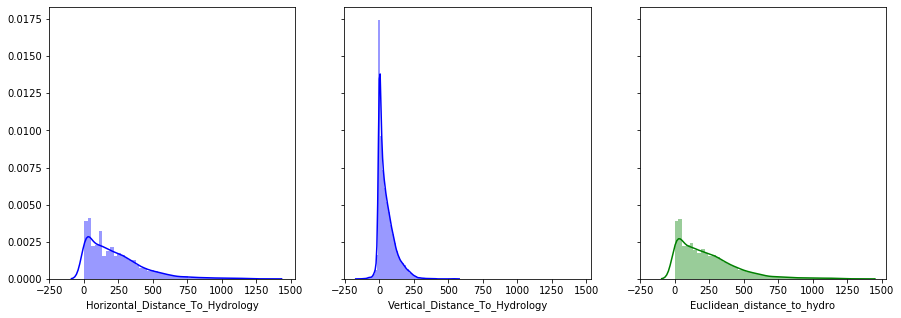

In [36]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sns.distplot(train_data_euc.Horizontal_Distance_To_Hydrology, color="b", ax=axes[0])
sns.distplot(train_data_euc.Vertical_Distance_To_Hydrology, color="b", ax=axes[1])
sns.distplot(train_data_euc['Euclidean_distance_to_hydro'], color="g", ax=axes[2])

Interpretation

The first plot (horizontal distance to hydrology) As expected, vegetation seems to be more abundant near hydrology.

The second plot (vertical distance), it seems that the negative values ​​could be vegetation superior to hydrology and the positive ones are vegetation inferior to hydrology. Most of the vegetation is in the downhill from hydrology with a huge amount of vegetation concentrated near 0 (high kurtosis), which means that much vegetation is at almost the same level of water.

When calculating the Euclidean distance to hydrology as a heuristic measure, we see that our third graph looks like the first, this is because the horizontal distance has a wider distribution compared to the horizontal distance where almost all values ​​are close to zero. However, this Euclidean distance is also better suited to the line, which will improve our model.


In [38]:
cv_rf_euc = cross_val(classifier_RF, X = train_data_euc)

[0.78849206 0.77103175 0.78115079]
Mean: 0.7802


The mean value of accuracy on cross-validation decreased. 

In [40]:
predict(classifier_RF, 'RF_euclidian', fit_model = True, X = train_data_euc, test = test_euc)

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) is fitted!
Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made 

array([2, 1, 2, ..., 3, 3, 3])

The score on public also decreased (0.74954). That means, that the feature does not help RF to make more accurate prediction. 

Let's form some other metafeatures from features, related to the distance:

In [41]:
def distances(df):
    # Horizontal distances measures
    cols = [
        'Horizontal_Distance_To_Roadways',
        'Horizontal_Distance_To_Fire_Points',
        'Horizontal_Distance_To_Hydrology',
    ]
    
    df['distance_mean'] = df[cols].mean(axis=1)
    df['distance_sum'] = df[cols].sum(axis=1)
    df['distance_road_fire'] = df[cols[:2]].mean(axis=1)
    df['distance_hydro_fire'] = df[cols[1:]].mean(axis=1)
    df['distance_road_hydro'] = df[[cols[0], cols[2]]].mean(axis=1)
    
    df['distance_sum_road_fire'] = df[cols[:2]].sum(axis=1)
    df['distance_sum_hydro_fire'] = df[cols[1:]].sum(axis=1)
    df['distance_sum_road_hydro'] = df[[cols[0], cols[2]]].sum(axis=1)
    
    df['distance_dif_road_fire'] = df[cols[0]] - df[cols[1]]
    df['distance_dif_hydro_road'] = df[cols[2]] - df[cols[0]]
    df['distance_dif_hydro_fire'] = df[cols[2]] - df[cols[1]]
    
    # Vertical distances measures
    colv = ['Elevation', 'Vertical_Distance_To_Hydrology']
    
    df['Vertical_dif'] = df[colv[0]] - df[colv[1]]
    df['Vertical_sum'] = df[colv].sum(axis=1)
    df['Vertical_mean'] = df[colv].mean(axis=1)
    
    return df

In [42]:
train_data_copy = train_data.copy()
test_copy = test.copy()

train_data_dist = distances(train_data_copy)
test_dist = distances(test_copy)

In [43]:
cv_rf_dist = cross_val(classifier_RF, train_data_dist)

[0.83115079 0.78769841 0.78015873]
Mean: 0.7997


Accuracy improved! Let's submit:

In [44]:
predict(classifier_RF, 'RF_dist', fit_model = True, X = train_data_dist, test = test_dist)

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) is fitted!
Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made 

array([1, 1, 1, ..., 3, 3, 3])

Score on public became 0.78289: definitely valuable features!

### Shade analysis

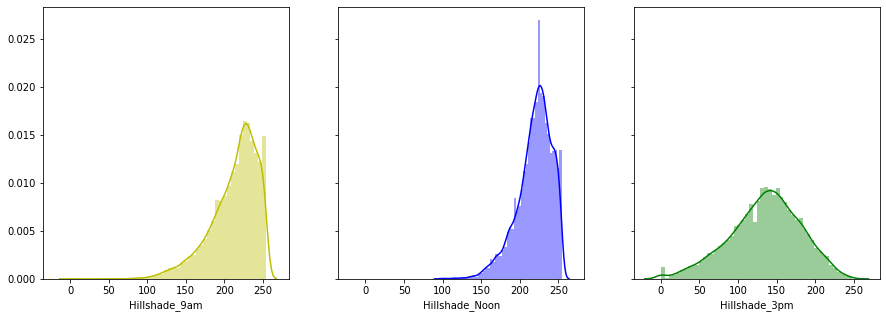

In [45]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sns.distplot(train_data['Hillshade_9am'], color="y", ax=axes[0])
sns.distplot(train_data['Hillshade_Noon'], color="b", ax=axes[1])
sns.distplot(train_data['Hillshade_3pm'], color="g", ax=axes[2])

In [46]:
train_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].kurt()

Hillshade_9am     1.218810
Hillshade_Noon    1.153484
Hillshade_3pm    -0.087344
dtype: float64

Interpretation

Here we can see the variation in the amount of sunlight among three different day hours. Between 9 am and noon, we see how the sunlight is increasing with a high positive kurtosis (>1) a huge peak in approx 225, that is almost the max value measurable (254).

By the 3 pm, there is a significant reduction of the light is some zones, (maybe by some hill), now the kurtosis is close to 0.


In [47]:
def shade(df):
    SHADES = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
    df['shade_noon_diff'] = df['Hillshade_9am'] - df['Hillshade_Noon']
    df['shade_3pm_diff'] = df['Hillshade_Noon'] - df['Hillshade_3pm']
    df['shade_all_diff'] = df['Hillshade_9am'] - df['Hillshade_3pm']
    df['shade_sum'] = df[SHADES].sum(axis=1)
    df['shade_mean'] = df[SHADES].mean(axis=1)
    return df

In [48]:
train_data_copy = train_data.copy()
test_copy = test.copy()

train_data_shade = shade(train_data_copy)
test_shade = shade(test_copy)

In [49]:
cv_rf_shade = cross_val(classifier_RF, X = train_data_shade)

[0.76904762 0.76011905 0.7734127 ]
Mean: 0.7675


In [50]:
predict(classifier_RF, 'RF_shade', fit_model = True, X = train_data_shade, test = test_shade)

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) is fitted!
Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made 

array([2, 2, 2, ..., 3, 3, 3])

Shade features led to the decrease of accuracy on public down to 0.72847 as well as on local cv.

### Soil analysis

In [51]:
# create a dict that map soil type with rockness
# 0=unknow 1=complex 2=rubbly, 3=stony, 
# 4=very stony, 5=extremely stony 6=extremely bouldery
soils = [
    [7, 15, 8, 14, 16, 17,
     19, 20, 21, 23], #unknow and complex 
    [3, 4, 5, 10, 11, 13],   # rubbly
    [6, 12],    # stony
    [2, 9, 18, 26],      # very stony
    [1, 24, 25, 27, 28, 29, 30,
     31, 32, 33, 34, 36, 37, 38, 
     39, 40, 22, 35], # extremely stony and bouldery
]

soil_dict = dict()
for index, values in enumerate(soils):
    for v in values:
        soil_dict[v] = index
        
        
def soil(df, soil_dict=soil_dict):
    df['Rocky'] =  sum(i * df['Soil_Type'+ str(i)] for i in range(1, 41))
    df['Rocky'] = df['Rocky'].map(soil_dict)
    return df

In [52]:
train_data_copy = train_data.copy()
test_copy = test.copy()

train_data_soil = soil(train_data_copy)
test_soil = soil(test_copy)

In [53]:
cv_rf_soil = cross_val(classifier_RF, train_data_soil)

[0.7906746  0.7702381  0.78095238]
Mean: 0.7806


In [54]:
# Predict the class
predict(classifier_RF, 'RF_soil', fit_model = True, X = train_data_soil, test = test_soil)

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) is fitted!
Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made 

array([2, 2, 2, ..., 3, 3, 3])

Public decreased down to 0.75064 comparing to baseline.

Just a nice picture with new feature.

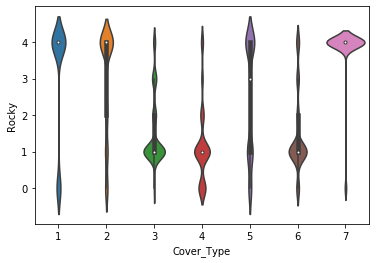

In [55]:
sns.violinplot(x = TARGET, y = 'Rocky', data=pd.concat([train_data_soil, train_labels], axis = 1))

### Elevation analysis

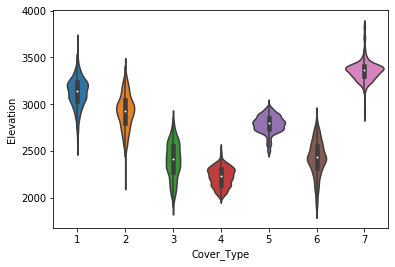

In [56]:
sns.violinplot(x = TARGET, y='Elevation', data=train, axis = 1)

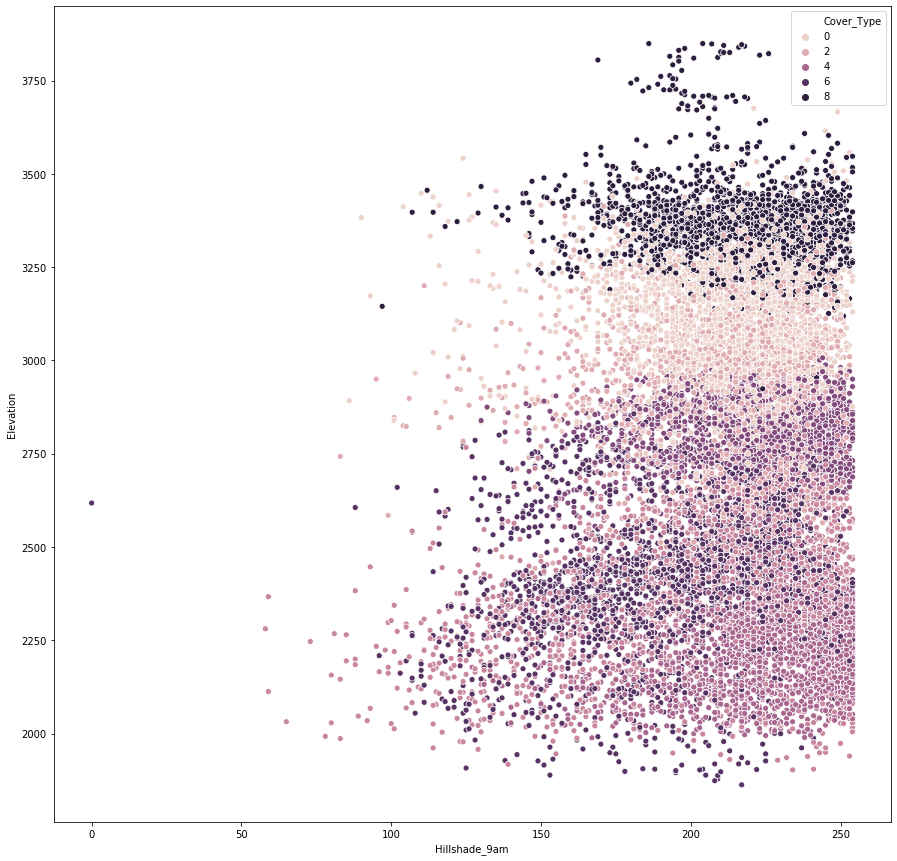

In [57]:
f, axes = plt.subplots(1, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(x='Hillshade_9am', y='Elevation', 
                hue=TARGET, data=train, y_jitter=True)

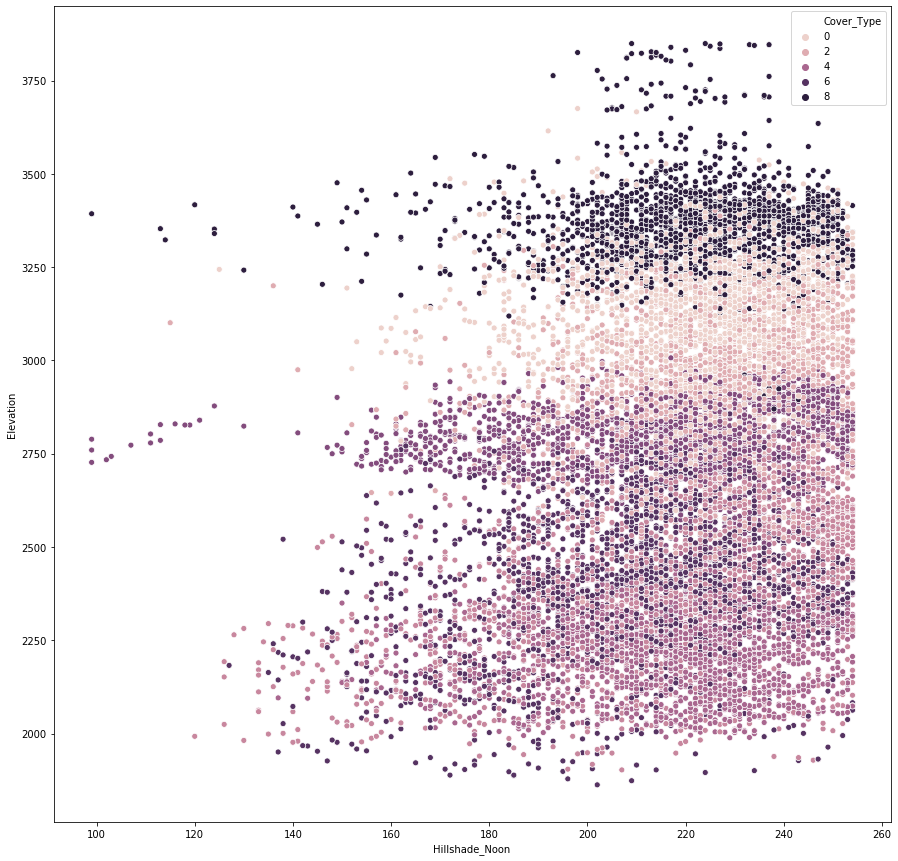

In [58]:
f, axes = plt.subplots(1, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(x='Hillshade_Noon', y='Elevation', 
                hue=TARGET, data=train, y_jitter=True)

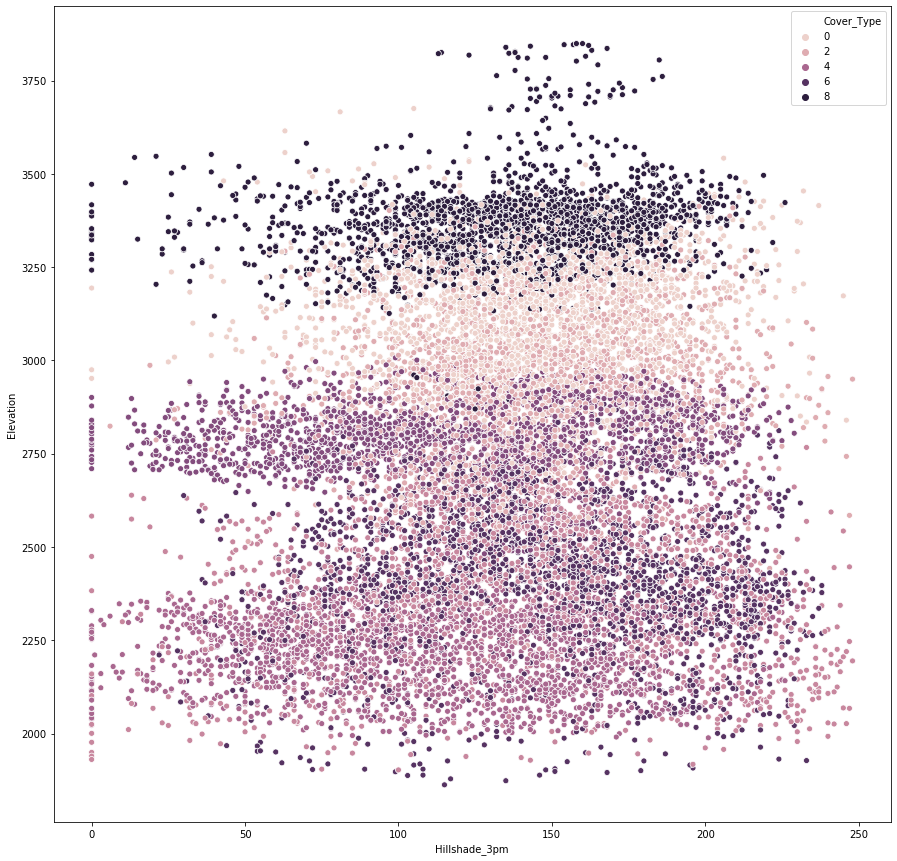

In [59]:
f, axes = plt.subplots(1, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(x='Hillshade_3pm', y='Elevation', 
                hue=TARGET, data=train, y_jitter=True)

### Slope and Aspect analysis

In [60]:
train[['Slope', 'Aspect']].describe()

Slope        Aspect
count  15120.000000  15120.000000
mean      16.501587    156.676653
std        8.453927    110.085801
min        0.000000      0.000000
25%       10.000000     65.000000
50%       15.000000    126.000000
75%       22.000000    261.000000
max       52.000000    360.000000

Slope and Aspect are degrees features, from 0 to 360 degrees

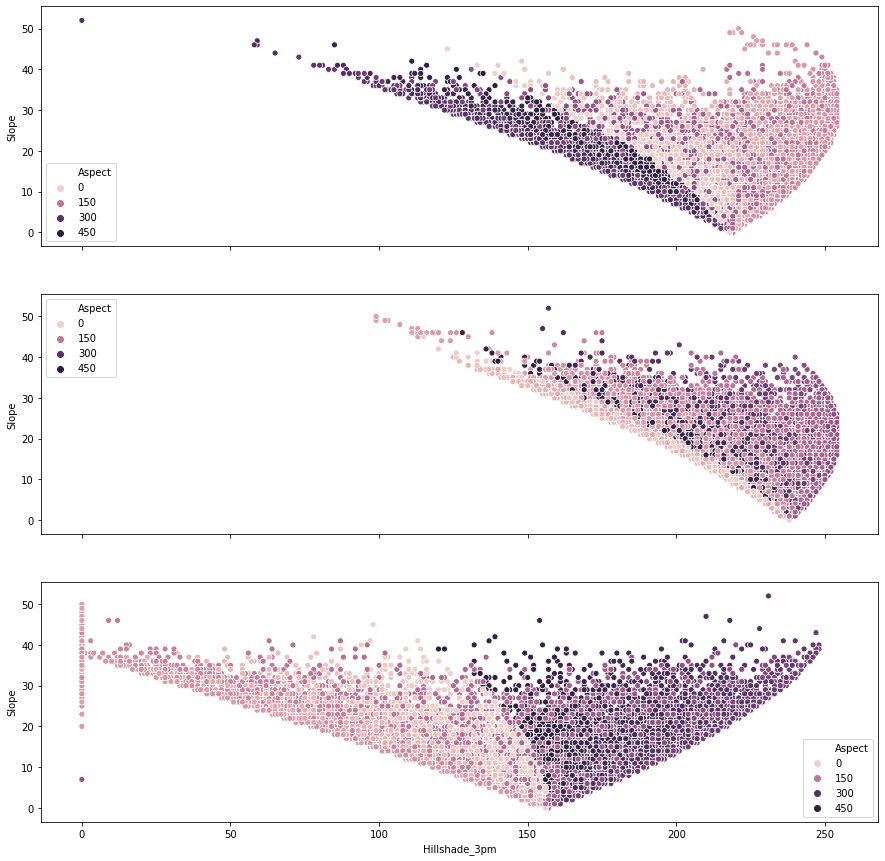

In [61]:
f, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(y='Slope', x='Hillshade_9am', 
                hue='Aspect', data=train_data, ax=axes[0])
sns.scatterplot(y='Slope', x='Hillshade_Noon', 
                hue='Aspect', data=train_data, ax=axes[1])
sns.scatterplot(y='Slope', x='Hillshade_3pm', 
                hue='Aspect', data=train_data, ax=axes[2])

In [62]:
def degree(df):
    #df['Aspect_cos'] = np.cos(np.radians(df.Aspect))
    df['Aspect_sin'] = np.sin(np.radians(df.Aspect))
    df['Slope_sin'] = np.sin(np.radians(df.Slope))
    df['Aspect_Slope'] = df.Slope * df.Aspect_sin
    #df['Aspectsin_Slope'] = df.Slope * df.Aspect_sin  
    return df

In [63]:
train_data_copy = train_data.copy()
test_copy = test.copy()

train_data_degree = degree(train_data_copy)
test_degree = degree(test_copy)

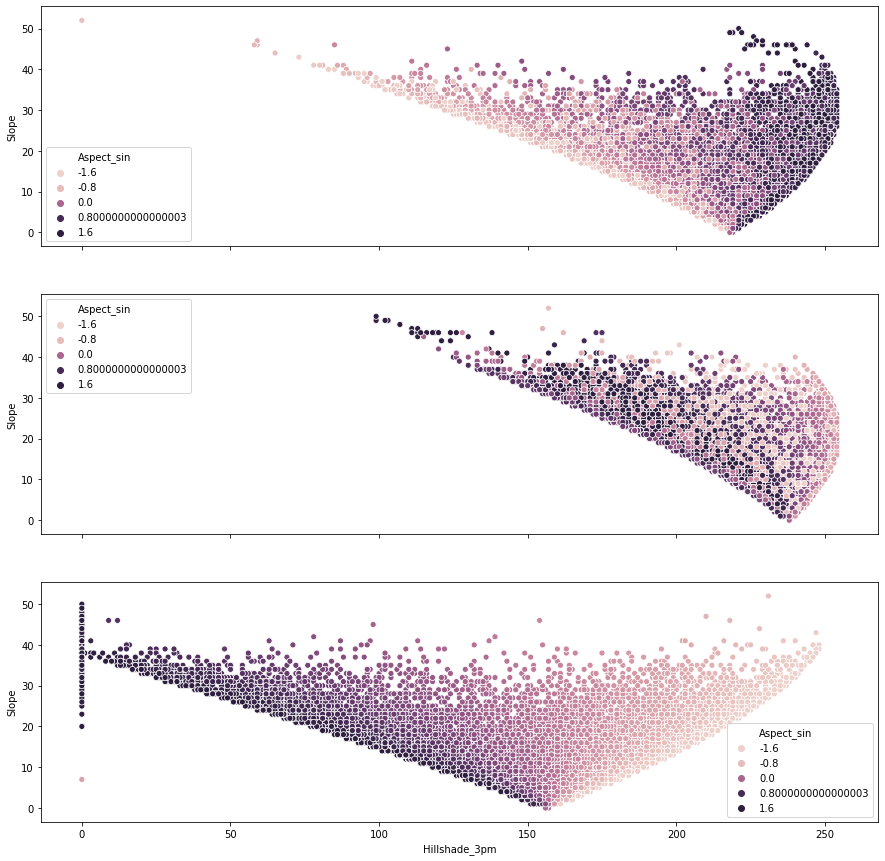

In [64]:
f, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(y='Slope', x='Hillshade_9am', 
                hue='Aspect_sin', data=train_data_degree, ax=axes[0])
sns.scatterplot(y='Slope', x='Hillshade_Noon', 
                hue='Aspect_sin', data=train_data_degree, ax=axes[1])
sns.scatterplot(y='Slope', x='Hillshade_3pm', 
                hue='Aspect_sin', data=train_data_degree, ax=axes[2])

Beautiful!!

This graphic is revealing.

At 9am, the sunlight is more intense on the slopes facing east, (darker points) and clearly, the larger the slope, the greater the difference in light between the east and west sides (light points).

The north and south points have intermediate light values and their variability continues to rise in relation to the slope.

At noon, all points seem to intermingle, this is because the sun is more distributed on all sides of the mountain.

By 3pm the difference is marked, this time you can visualize beautifully in this graph as the east side has much less light than the west side.


In [65]:
cv_rf_degree = cross_val(classifier_RF, train_data_degree)

[0.78452381 0.76468254 0.77440476]
Mean: 0.7745


In [66]:
predict(classifier_RF, 'RF_degree', fit_model = True, X = train_data_degree, test = test_degree)

Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) is fitted!
Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False) made 

array([2, 1, 2, ..., 3, 3, 3])

Score on public decreased down to 0.73770 comparing to RF baseline.

Only distance features improved accuracy on cv and public, so we are going to add only them:

In [68]:
train_data = distances(train_data)
test = distances(test)

In [69]:
cv_rf_features = cross_val(classifier_RF, train_data)

[0.83115079 0.78769841 0.78015873]
Mean: 0.7997


In [70]:
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [71]:
test.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40